In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

## Load and validate tweets

In [2]:
df = pd.read_csv('GPU_1414.csv', delimiter=',')
df1 = pd.read_csv('CPU_3337.csv', delimiter=',')
df2 = pd.read_csv('GPU_1100.csv', delimiter=',')
df3 = pd.read_csv('processors_570.csv', delimiter=',')
df4 = pd.read_csv('PC_1100.csv', delimiter=',')
df5 = pd.read_csv('CPU_5000.csv', delimiter=',')
df6 = pd.read_csv('APU_5000.csv', delimiter=',')

In [3]:
df_con = pd.concat([df, df1, df2, df3, df4, df5, df6])
df = df_con.drop_duplicates(subset=['text'])
df.shape

(15968, 12)

In [4]:
df = df[['date', 'username', 'text']]
df = df.dropna()
df.shape

(15967, 3)

In [5]:
df['date'].min()

'2007-07-13 03:04:39'

In [6]:
df['date'].max()

'2020-07-10 02:25:58'

In [7]:
def cut_date(s):
    return s[:10]

df['date'].map(cut_date).value_counts()

2020-07-09    7493
2020-07-08    1655
2020-07-10    1429
2020-07-07     164
2011-04-15      27
              ... 
2017-02-08       1
2016-04-22       1
2018-07-29       1
2012-04-15       1
2016-03-24       1
Name: date, Length: 2658, dtype: int64

In [8]:
len(df['username'].value_counts())

10323

## NLP preprocessing

In [9]:
%%time
# tokenization = split sentences into word strings
df['tokens'] = df['text'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s", "since"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 13.3 s


In [10]:
pd.set_option('display.max_rows', 4200)

#create [[str, str,...] ...] and chain(*) returns each str in each list 
all_words = pd.Series(chain(*list(df['processed']))) 
word_frequency = all_words.value_counts()
word_frequency[:400]

cpu                 5645
gpu                 1814
http                1452
pc                  1425
…                   1045
’                    917
new                  849
wa                   840
get                  822
apu                  789
like                 756
time                 744
ha                   744
one                  720
got                  620
need                 585
game                 559
processor            557
day                  518
would                499
intel                475
've                  460
amd                  450
2                    436
ram                  430
good                 428
use                  412
de                   411
want                 390
know                 387
still                385
also                 383
year                 373
think                360
work                 348
first                345
u                    338
really               338
go                   337
na                   335


### Brands to compare

In [11]:
brands = ["amd", "intel", "nvidia"]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brands)
brand_frequency = word_frequency[mask]
top_brands = brand_frequency.head(4)
top_brands

intel     475
amd       450
nvidia    165
dtype: int64

## Lift ratio between brands

In [12]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

In [13]:
lift_brands = pd.DataFrame(top_brands.index.values, columns=['brands']) #initialize df 
for brand in top_brands.index.values:
    lift_brands[brand] = lift_brands['brands'].map(lambda x: lift(x, brand)) #create lift column for each candidate 
lift_brands = lift_brands.set_index('brands')
lift_brands

,intel,amd,nvidia
brands,,,
intel,34.117521,7.069396,3.178651
amd,7.069396,35.961712,10.721504
nvidia,3.178651,10.721504,99.173913


## Attribute connections

In [14]:
word_frequency[:400]

cpu                 5645
gpu                 1814
http                1452
pc                  1425
…                   1045
’                    917
new                  849
wa                   840
get                  822
apu                  789
like                 756
time                 744
ha                   744
one                  720
got                  620
need                 585
game                 559
processor            557
day                  518
would                499
intel                475
've                  460
amd                  450
2                    436
ram                  430
good                 428
use                  412
de                   411
want                 390
know                 387
still                385
also                 383
year                 373
think                360
work                 348
first                345
u                    338
really               338
go                   337
na                   335


In [15]:
attribute_dict = {"positive":["like", "get", "got","need", "good", "want", "better", "buy",\
                              "upgrade", "love", "pretty", "great", "bought", "nice", "support"\
                              "pro", "wanted", "happy"],
                  "negative":["hot", "issue", "problem", "shit", "bad", "broke"],
                  "performance":["speed", "power", "preformance"],
                  "gaming":["gaming", "stream", "xbox", "streaming"],
                  "price":["money", "price"],
                  "quality":["hardware", "software"],
                  "security":["security"],
                  "student":["school"]}

In [16]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attribute = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attribute['count'] = top_attribute['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attribute.sort_values(by=['count'], ascending=False)

,attribute_terms,count
positive,"[like, get, got, need, good, want, better, buy...",3842
negative,"[hot, issue, problem, shit, bad, broke]",841
gaming,"[gaming, stream, xbox, streaming]",481
performance,"[speed, power, preformance]",385
price,"[money, price]",203
quality,"[hardware, software]",142
security,[security],68
student,[school],64


In [17]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brands:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [18]:
brands

['amd', 'intel', 'nvidia']

positive
amd       1.553786
nvidia    1.419720
intel     1.056737
dtype: float64

negative
nvidia    2.358476
amd       1.325580
intel     0.567949
dtype: float64

performance
intel     1.772339
amd       1.401106
nvidia    0.000000
dtype: float64

gaming
amd       2.242934
nvidia    2.061828
intel     1.205817
dtype: float64

price
amd       4.428782
nvidia    4.396873
intel     2.184866
dtype: float64

quality
intel     4.565020
amd       3.039018
nvidia    1.396816
dtype: float64

security
intel     15.051848
amd        8.990428
nvidia     0.000000
dtype: float64

student
intel     1.066173
nvidia    0.000000
amd       0.000000
dtype: float64



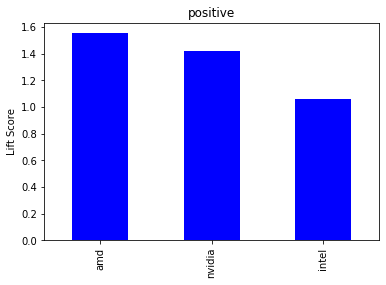

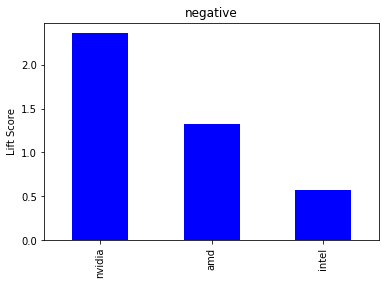

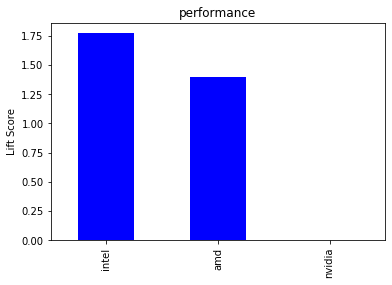

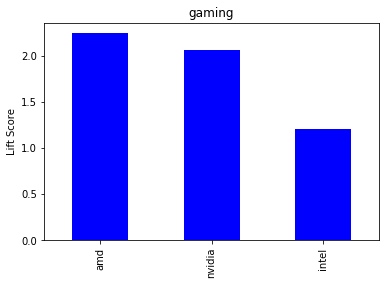

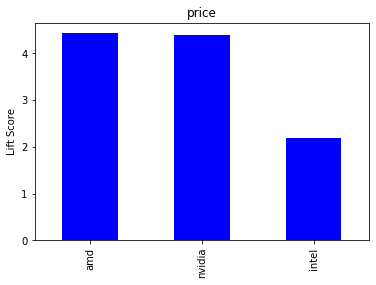

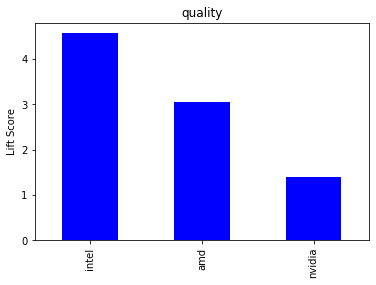

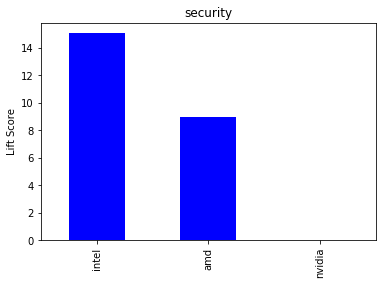

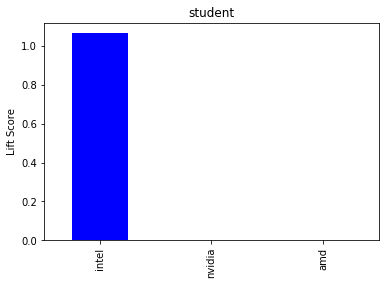

In [25]:
%matplotlib inline
from itertools import cycle, islice
from matplotlib import pyplot as plt

brands_list = brands

for attribute in top_attribute.index.values:
    output = lift_attribute_to_brands(attribute, attribute_dict, brands, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(attribute)
    print(output)
    print('')
    plt.figure()
    plt.title(attribute)
    plt.ylabel("Lift Score")
    my_colors = list(islice(cycle(['blue']), None, len(df)))
    output.plot(kind='bar', stacked=True, color=my_colors)

## Sentiment analysis

In [20]:
%%time
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['text'].apply(lambda review:sid.polarity_scores(review)['compound'])

Wall time: 7.37 s


In [21]:
def lift_attribute_to_brands2(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    sentiment = dict()
    for brand in brands:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        df_ab = df_a[df_a['processed'].map(lambda x: brand in x)] # df w/ attribute and brand    
        
        output[brand] = N*N_ab/(N_a*N_b)
        sentiment[brand] = df_ab['sentiment_scores'].mean()

    check = pd.concat([pd.Series(output), pd.Series(sentiment)], axis=1)
    check.columns = ['lift', 'sentiment']
    return(check)

In [22]:
candidates_list = pd.Series(index=['amd', 'intel', 'nvidea'])

for attribute in top_attribute.index.values:
    print(attribute)
    output = lift_attribute_to_brands2(attribute, attribute_dict, brands, df)
    output = output.sort_values(by=['lift'], ascending=False)
    print(output)
    print('')

positive
            lift  sentiment
amd     1.553786   0.318307
nvidia  1.419720   0.217400
intel   1.056737   0.268735

negative
            lift  sentiment
nvidia  2.358476  -0.088280
amd     1.325580   0.301055
intel   0.567949   0.045571

performance
            lift  sentiment
intel   1.772339   0.210775
amd     1.401106   0.103887
nvidia  0.000000        NaN

gaming
            lift  sentiment
amd     2.242934   0.361913
nvidia  2.061828  -0.013910
intel   1.205817   0.577006

price
            lift  sentiment
amd     4.428782   0.258748
nvidia  4.396873   0.325100
intel   2.184866   0.176285

quality
            lift  sentiment
intel   4.565020  -0.025363
amd     3.039018   0.174850
nvidia  1.396816  -0.030400

security
             lift  sentiment
intel   15.051848   0.205700
amd      8.990428   0.042971
nvidia   0.000000        NaN

student
            lift  sentiment
intel   1.066173    0.51925
amd     0.000000        NaN
nvidia  0.000000        NaN

